In [1]:
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import auc, roc_curve

In [2]:
def get_roc(filename):

    df = pd.read_csv(filename)
    n_sig_verts = df["n_signal_vertices"][0]
    model = df["generating_func"][0]
    model = "magnitude" if model == 'generate_graphs_1' else "rotate"

    rocs = []

    for method in ["omni", "mdmr", "stats", "nbs_dcorr", "nbs_ttest"]:
        fpr, tpr, _ = roc_curve(df["label"], df[method], pos_label=0, drop_intermediate=False)
        auroc = auc(fpr, tpr)
        tmp = pd.DataFrame({"method": method, "fpr": fpr, "tpr": tpr, "auroc": auroc})
        rocs.append(tmp)
    
    # Make dataframe of ROCs
    rocs = pd.concat(rocs)
    df.reset_index(level=0, inplace=True, drop=True)
    rocs["n_sig_verts"] = n_sig_verts
    rocs["model"] = model
    
    return rocs

In [3]:
files = glob("results/tmp/*.csv")
files = [f for f in files if "/0-" not in f]
frames = [get_roc(filename) for filename in files]
df = pd.concat(frames)
df.reset_index(level=0, inplace=True, drop=True)

df.head()

,method,fpr,tpr,auroc,n_sig_verts,model
0,omni,0.0,0.00,0.9952,25,magnitude
1,omni,0.0,0.04,0.9952,25,magnitude
2,omni,0.0,0.08,0.9952,25,magnitude
3,omni,0.0,0.12,0.9952,25,magnitude
4,omni,0.0,0.16,0.9952,25,magnitude


In [4]:
df["method"].unique()

array(['omni', 'mdmr', 'stats', 'nbs_dcorr', 'nbs_ttest'], dtype=object)

In [5]:
unique_params = df.groupby(["n_sig_verts", "model"]).size().reset_index().drop(columns=[0])
unique_params

,n_sig_verts,model
0,5,magnitude
1,5,rotate
2,10,magnitude
3,10,rotate
4,15,magnitude
5,15,rotate
6,20,magnitude
7,20,rotate
8,25,magnitude
9,25,rotate


In [6]:
def replace(method):
    if method == "omni":
        return "OMNI"
    elif method == "mdmr":
        return "MDMR"
    elif method == "stats":
        return "ERGM"
    elif method == "nbs_dcorr":
        return "NBS (DCorr)"
    elif method == "nbs_ttest":
        return "NBS (T-test)"

df["Method"] = df["method"].apply(replace)
df.head()

,method,fpr,tpr,auroc,n_sig_verts,model,Method
0,omni,0.0,0.00,0.9952,25,magnitude,OMNI
1,omni,0.0,0.04,0.9952,25,magnitude,OMNI
2,omni,0.0,0.08,0.9952,25,magnitude,OMNI
3,omni,0.0,0.12,0.9952,25,magnitude,OMNI
4,omni,0.0,0.16,0.9952,25,magnitude,OMNI


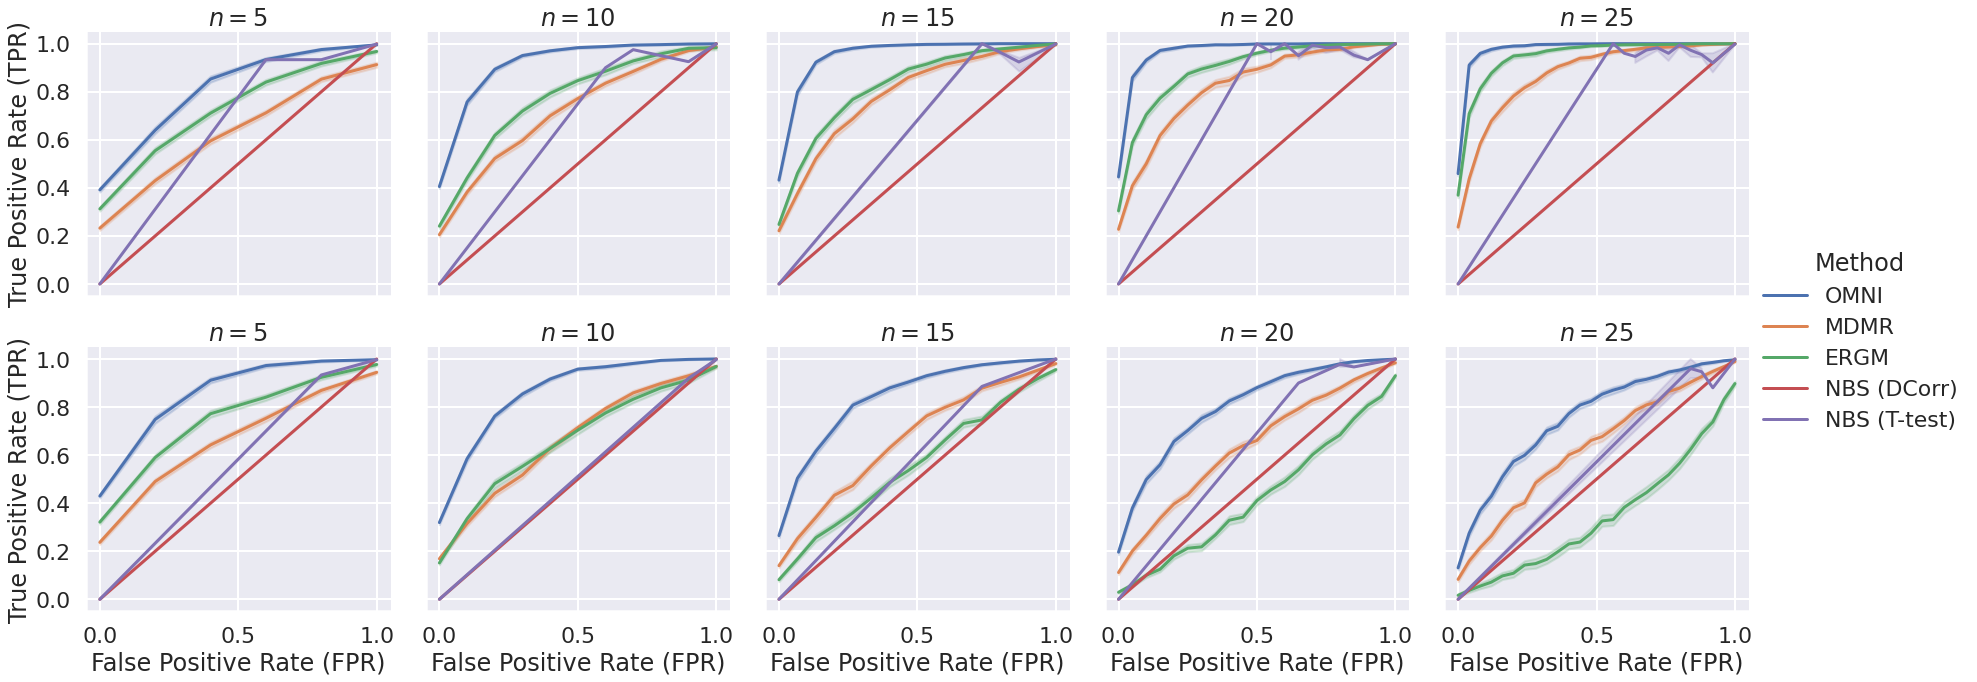

In [7]:
sns.set_theme(context="poster", style="darkgrid")

g = sns.relplot(
    x="fpr",
    y="tpr",
    hue="Method",
    col="n_sig_verts",
    row="model",
    kind="line",
    data=df,
)

for ax, n in zip(g.axes.flatten(), [5, 10, 15, 20, 25] * 2):
    ax.set(title=f"$n={{{n}}}$")
g.set(xlabel="False Positive Rate (FPR)", ylabel="True Positive Rate (TPR)")

plt.savefig("vertex_sim.pdf")

In [8]:
aurocs = df.groupby(["auroc", "Method"]).size().reset_index().drop(columns=[0])

print(aurocs.query("Method == 'ERGM'").auroc.mean())
print(aurocs.query("Method == 'MDMR'").auroc.mean())
print(aurocs.query("Method == 'OMNI'").auroc.mean())
print(aurocs.query("Method == 'NBS (DCorr)'").auroc.mean())
print(aurocs.query("Method == 'NBS (T-test)'").auroc.mean())

0.6803136727505604
0.7252464024481267
0.8685661315808375
0.5
0.5850609591354272
